###  Описание проекта:
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

In [156]:
# Импортируем все необходимые для анализа библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})
import scipy.stats as stats
from scipy import stats as st
import math
import numpy as np
import datetime as dt

### Подгрузим датасеты, проверим их на наличие пропусков и соответствие типам данных, а также правильность выгрузки данных

In [157]:
# Считаем данные о заказах и сохраним в датафрейм 
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
# Приведем данные к нужному виду, предварительно создав дополнительную колонку с непосредственной датой (днем, месяцем и годом) каждого заказа
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
# Выведем информацию о данных
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()
orders.head(5)


Начальная дата 2019-08-01, конечная дата 2019-08-31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [158]:
# Проделаем все тоже самое с данными о визитах в группах А и В
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()
visitors.head(5)
print('\nРезультаты подготовки:\nДанные прочитали, изменили тип данных у столбцов с датами, выгрузка совершена корректно, даты совпадают.')


Начальная дата 2019-08-01, конечная дата 2019-08-31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB

Результаты подготовки:
Данные прочитали, изменили тип данных у столбцов с датами, выгрузка совершена корректно, даты совпадают.


In [160]:
# Сохраним данные о приоритезации гипотез в отдельный датасет 
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


## 1.  Приоритизация гипотез
### 1.1 Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета

In [161]:
# Расчитаем ICE 
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [162]:
hypothesis.sort_values('ICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000


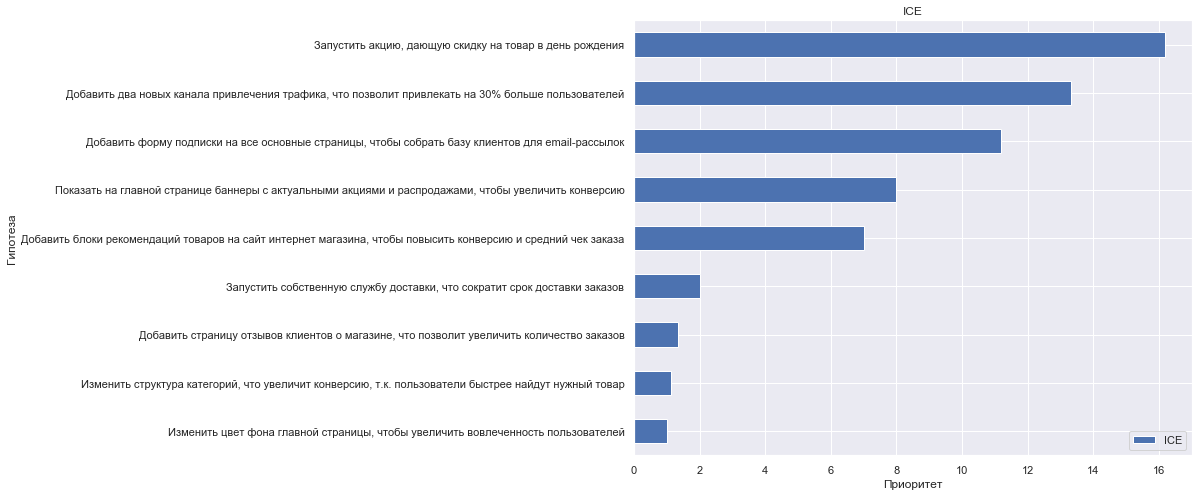

In [163]:
ax = hypothesis[['Hypothesis', 'ICE']].set_index('Hypothesis').sort_values('ICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('ICE')
plt.show()

### 1.2 Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета

In [164]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [165]:
hypothesis.sort_values('RICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


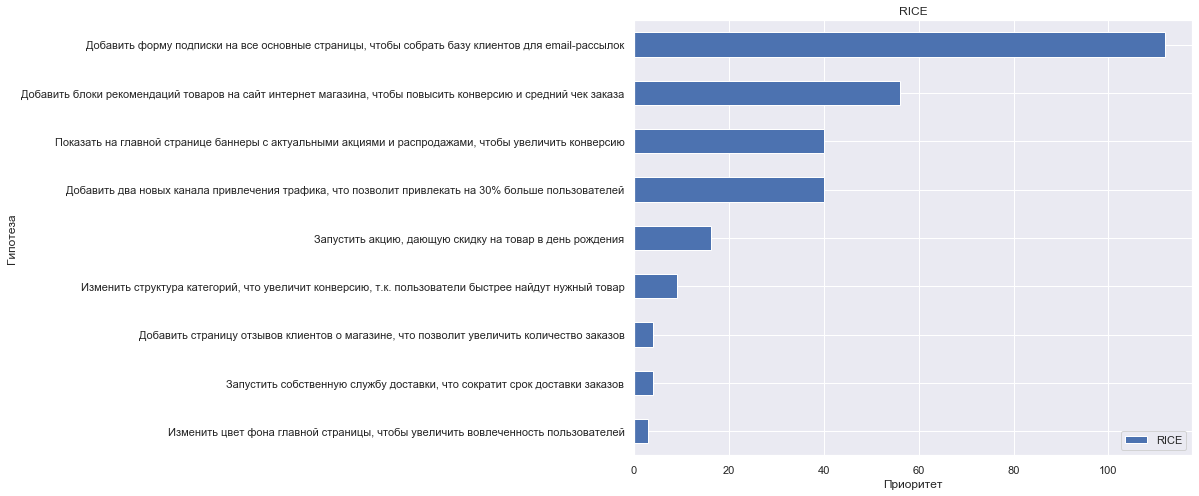

In [166]:
ax = hypothesis[['Hypothesis', 'RICE']].set_index('Hypothesis').sort_values('RICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('RICE')
plt.show()

    По фреймворку ICE наибольшую оценку имели гпиотезы 8,0 и 7. После применения фреймворка RICE приоритеты изменились на гпиотезы 7,2 и 0. Это объясняется тем, что в случае фреймворка ICE в отличие от RICE мы не учитывали охват изменений, тогда как это важная составляющая оценки гипотез.

    В нашем случае наиболее приоритетными гипотезами будут 7, 2, 0. 


### 2. Анализ А/В тестов по метрикам изменения конверсии и среднего чека 
#### 2.1 Проверим корректность распределения на группы A/B и некоторых других параметров эксперимента: время, размер выборки 

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


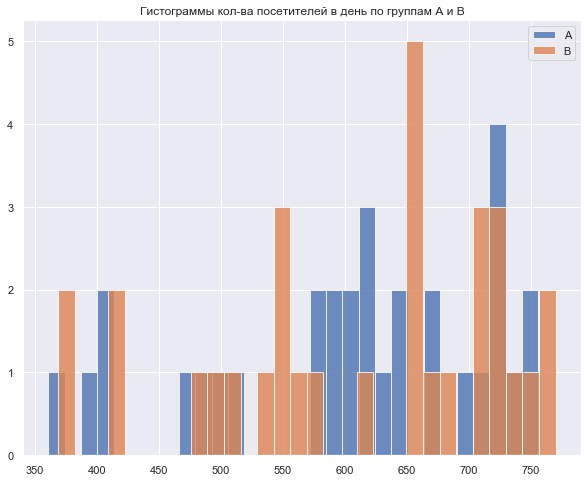

P-value:0.36506882746952496
Разница в количестве посетителей в группах A и B статистически НЕ значима

Начальная конверсия: 0.030
Полученная после изменений конверсия: 0.034
Относительное изменение конверсии после изменений: 0.121

Вводим начальную конверсию и полученное относительное изменение конверсии в калькулятор
Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html
Получаем необходимое количество выборки 35855 для корректного проведения тестирования
В нашем случае количество 37652 посещений
Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницы
в количестве посещений м/у группами не обнаружено



In [192]:
# Посчитаем количество ВСЕХ (не только уникальных) пользователей в обеих группах, чтобы определить размеры подвыборок
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
# Посчитаем количество покупок ВСЕХ клиентов в обеих группах для того, чтобы в дальнейшем определить относительную конверсию
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))
plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8, label='A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, label='B', bins = 30)
plt.legend()
plt.title('Гистограммы кол-ва посетителей в день по группам A и B')
plt.show();
# Проведем непараметрический тест Манна-Уитни для того, чтобы оценить статистически значимые различия между выборками. 
# Переформулируем гипотезу о равенстве средних рангов на язык бизнес-логики 
results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

initial_conversion = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()
print('Начальная конверсия: {:.3f}'.format(initial_conversion))
print('Полученная после изменений конверсия: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.3f}'.format(abs(1-(initial_conversion/resulting_conversion))))
print('\nВводим начальную конверсию и полученное относительное изменение конверсии в калькулятор\n'
     'Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html\n'
     'Получаем необходимое количество выборки 35855 для корректного проведения тестирования\n'
     'В нашем случае количество {} посещений\n'
      'Кол-во выборки для A/B тестирования корректно подобрано, ' 
      'статистически значимой разницы\nв количестве посещений м/у группами не обнаружено\n'.format(visitors['visitors'].sum()))

#### 2.2 Построение графика комулятивной выручки по группам

In [167]:
#достаем уникальные значения дат и групп А и В 
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])
datesGroups

,date,group
55,2019-08-01,A
66,2019-08-01,B
175,2019-08-02,A
173,2019-08-02,B
291,2019-08-03,A
...,...,...
496,2019-08-29,B
730,2019-08-30,A
690,2019-08-30,B
958,2019-08-31,A


In [171]:
#выводим кумулятивные показатели из orders
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
                                     .agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis = 1)\
                                     .sort_values(by=['date','group'])

ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
ordersAggregated.head(3)


,date,group,orders,buyers,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401


In [172]:
# Выведем куммулятивные показатели данные по визитам, по аналогии с заказами
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'], x['group']==visitors['group'])]\
                                       .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)\
                                       .sort_values(by=['date','group'])

#сводим все накопительные данные в одну таблицу
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.head(3)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338


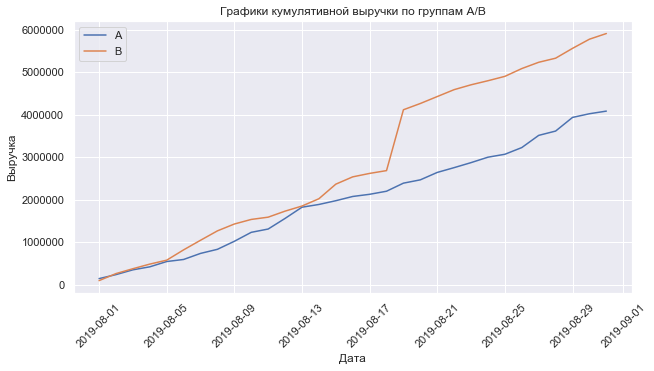

Выводы:
Как мы видим, группа B стабильно показывает большую выручку чем группа A, однако, мы наблюдаем резкий скачок показателей выручки с 18 Августа.


In [178]:
# Построим график комулятивной выручки по группам А и В
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']
plt.figure(figsize=(10,5))
plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue'], label = 'A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.xticks(rotation=45)
plt.legend()
plt.show()
print('Выводы:')
print('Как мы видим, группа B стабильно показывает большую выручку чем группа A, однако, мы наблюдаем резкий скачок показателей выручки с 18 Августа.')

#### 2.3 Построение графика кумулятивного среднего чека по группам.

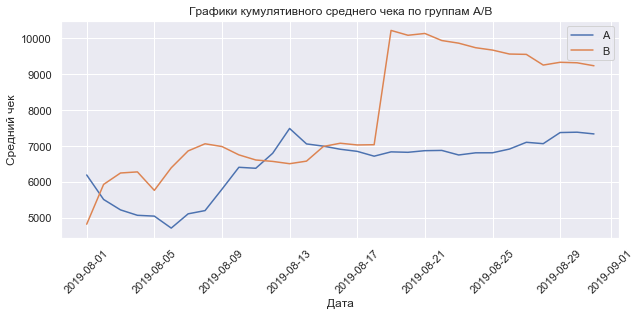

Выводы:
Как мы видим, средний чек в группе B почти всё время был выше среднего чека в группе А, но нас должно 
смутить его резкое колебание во второй половине графика, есть вероятность что оно обусловлено аномалиями. 
Принимаем во внимание тот факт, что средний чек клиентов группы В лидирует над группой клиентов А именно благодаря аномальному скачку.


In [181]:
plt.figure(figsize=(10,4))
plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue']/cummulativeDataA['orders'], label = 'A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue']/cummulativeDataB['orders'], label = 'B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.legend()
plt.show()
print('Выводы:')
print('Как мы видим, средний чек в группе B почти всё время был выше среднего чека в группе А, но нас должно \nсмутить '
      'его резкое колебание во второй половине графика, есть вероятность что оно обусловлено аномалиями. \nПринимаем во внимание тот факт, что средний чек клиентов группы В лидирует над группой клиентов А именно благодаря аномальному скачку.')

#### 2.4 Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

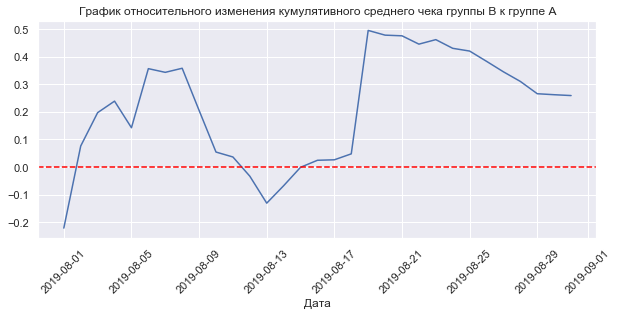

Выводы:
Из графика мы валидируем отмеченные выше колебания в среднем чеке, колебания слишком резкие, необходимо будет проверить данные на наличие аномальных пользователей: клиентов с экстремально высокими показателями средних чеков


In [184]:
# Смерджим данные о куммулятивном среднем чеке групп А и В 
mergedCummulativeData = cummulativeDataA.merge(cummulativeDataB, left_on='date', right_on='date', suffixes=['A', 'B'])
mergedCummulativeData.head(5)
plt.figure(figsize=(10,4))
plt.plot(mergedCummulativeData['date'], ((mergedCummulativeData['revenueB']/mergedCummulativeData['ordersB'])/
                                       (mergedCummulativeData['revenueA']/mergedCummulativeData['ordersA'])-1))
plt.axhline(y=0, color='red', linestyle = '--')
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.show()
print('Выводы:')
print('Из графика мы валидируем отмеченные выше колебания в среднем чеке, колебания слишком резкие, необходимо будет проверить данные на наличие аномальных пользователей: клиентов с экстремально высокими показателями средних чеков')

#### 2.5 Построение графика кумулятивной конверсии по группам

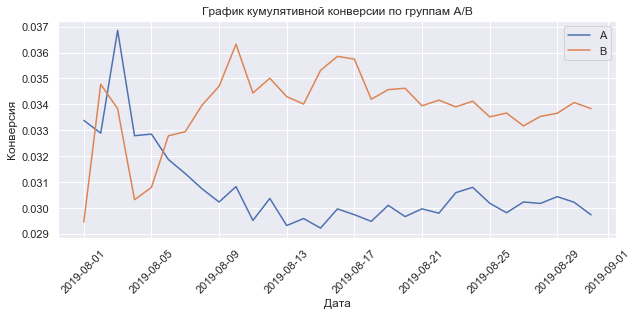

Выводы:
В начале теста конверсии обоих групп демонстрируют чрезвычайную флюидность и на 5-й день эксперимента в лидеры по конверсии 
 выходят клиенты группы А, затем к концу первой недели начинает постеменно лидировать группа В. К концу теста мы наблюдаем плато.


In [188]:
# Добавим переменную с конверсией к сводному датафрейму
mergedCummulativeData['conversionA'] =  mergedCummulativeData['ordersA'] / mergedCummulativeData['visitorsA'] 
mergedCummulativeData['conversionB'] =  mergedCummulativeData['ordersB'] / mergedCummulativeData['visitorsB']
mergedCummulativeData.head(5)
plt.figure(figsize=(10,4))
plt.plot(mergedCummulativeData['date'], mergedCummulativeData['conversionA'], label='A')
plt.plot(mergedCummulativeData['date'], mergedCummulativeData['conversionB'], label='B')
plt.title('График кумулятивной конверсии по группам A/B')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()
print('Выводы:')
print('В начале теста конверсии обоих групп демонстрируют чрезвычайную флюидность и на 5-й день эксперимента в лидеры по конверсии \n выходят клиенты группы А, затем к концу первой недели начинает постеменно лидировать группа В. К концу теста мы наблюдаем плато.')
      
      
      

#### 2.6 Построение графика относительного изменения конверсии группы В к группе А

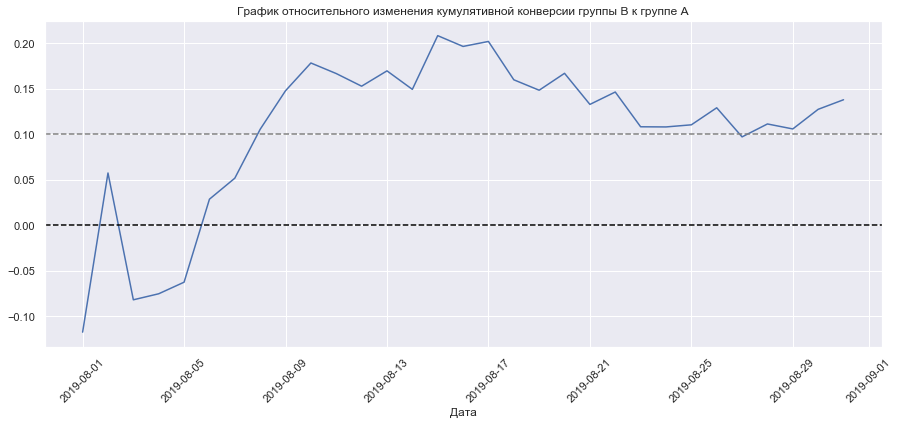

Выводы:
Конверсия в группе B стабильно лучше конверсии в группе A на 10% по просшествии 1 недели после начала


In [193]:
mergedCummulativeData.head(5)
plt.figure(figsize=(15,6))
plt.plot(mergedCummulativeData['date'], ((mergedCummulativeData['conversionB']/mergedCummulativeData['conversionA'])-1))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()
print('Выводы:')
print('Конверсия в группе B стабильно лучше конверсии в группе A на 10% по просшествии 1 недели после начала')

### 3. Анализ выбросов и всплесков
#### 3.1 Построение точечного графика кол-ва заказов по пользователям

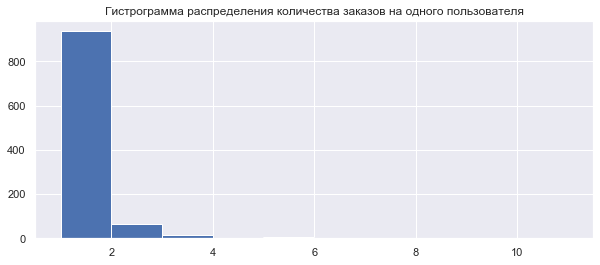

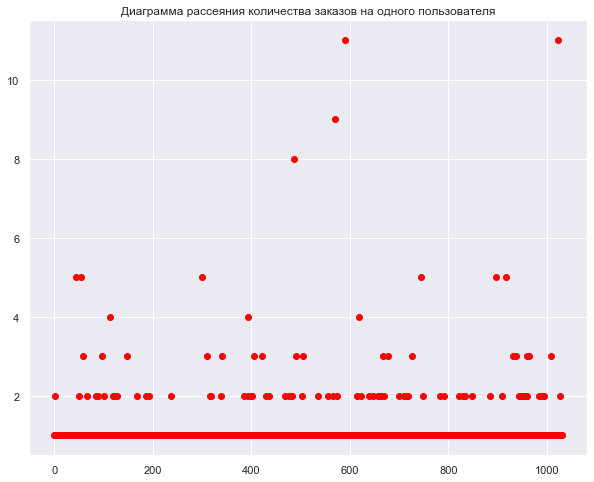

In [195]:
# Построим гистограмму распределения количества уникальных заказов на одного пользователя
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})\
                       .rename(columns={'transactionId':'orders'})
plt.figure(figsize=(10,4))
plt.hist(ordersByUsers['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()
# Построим скаттер-плот для того, чтобы оценить вариативность признака и задетектить экстремально высокие значения
x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders'], color='red')
plt.title('Диаграмма рассеяния количества заказов на одного пользователя')
plt.show()

    Из графика мы можем сделать вывод о том, что чаще всего пользователи делают 2 заказа на сервисе, однако, не редки случаи, когда клиенты совершают более 3-х заказов. В некоторых случая в одной или в обоих группах мы наблюдаем экстремально высокие показатели покупок, сильно смещающих оценку относительных показателей метрик. Определим 95-й и 99-й процентили количества заказов для того, чтобы избавиться на данном этапе от выбросов

In [196]:
percentiles = np.percentile(ordersByUsers['orders'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 2.0
99: 4.0


    Итак, более 2-х заказов совершают не более 5% клиентов, более 4 - не более 1%

#### 3.2 Построим точечный график стоимостей заказов

2978.0

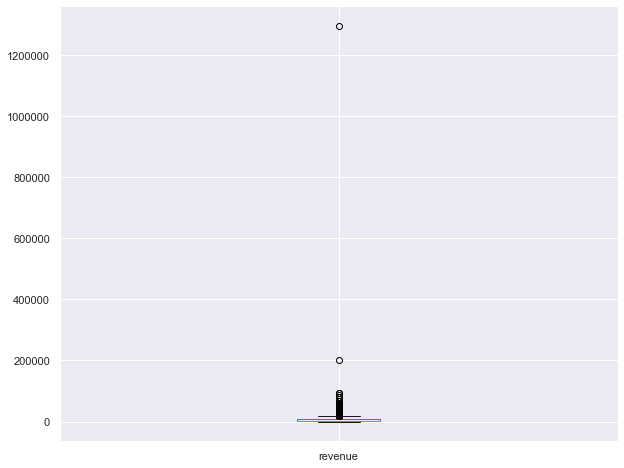

In [204]:
# Для начала построим boxplot для того, чтобы оценить меру изменчивости признака на максимальных и минимальных значениях:
# Обнаруживаем, что в данных присутствуют клиенты с рекордно высокими суммами покупок > 1200000 руб при медианном значении около 3 т.р.
orders.plot(kind='box', y='revenue');
orders['revenue'].describe()
orders['revenue'].median()

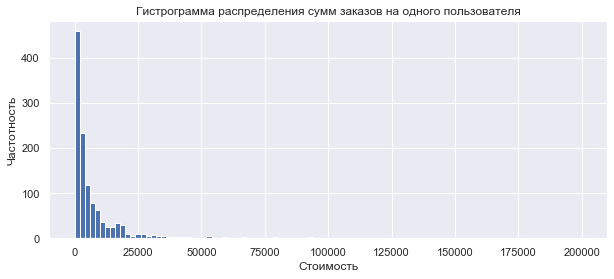

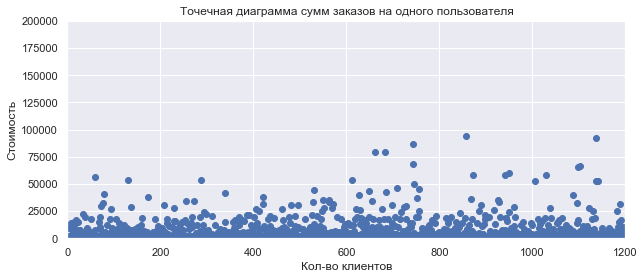

Выводы:
Судя по графикам, большая часть пользователей делает покупки суммой не больше 25-30 т.р. Проверим это далее на 95-м, 99-м процентилях


In [207]:
# Построим гистограмму распределения стоимости заказов на одного пользователя в срезе до 200 т.р.
plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0, 200000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.xlabel('Стоимость')
plt.ylabel('Частотность')
plt.show()
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
# Построим диаграмму размаха дохода по пользователям 
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.xlabel('Кол-во клиентов')
plt.ylabel('Стоимость')
plt.show()
print('Выводы:')
print('Судя по графикам, большая часть пользователей делает покупки суммой не больше 25-30 т.р. Проверим это далее на 95-м, 99-м процентилях')

In [208]:
percentiles = np.percentile(orders['revenue'], [95, 99])
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 28000
99: 58233


    Итак, не более 5 % клиентов совершают покупки на сумму более 28000 руб, не более 1 % - на сумму более 58 т.р

#### 3.2 Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным

    Статистически значимые различия в конверсии можно проверить, применив z-тест (так как в конверсиях у нас не может быть выбросов) , сравним результаты с непараметрическим тестом Манна Уитни. 

    В проекте (да и в тренажере тоже) мы используем Манна-Уитни при оценке конверсии и среднего чека. Однако, применение теста Манна-Уитни  для конверсии ограничено тем, что он плохо работает на выборках, где много нулей (а конверсия это у нас как раз такая выборка: мы получаем массив данных в котором 17500 значений нули и 500 значений не нули - см. ниже). В таком случае, акутализируется применение z-теста, который проверяет более понятную гипотезу, нежели М-У (Два распределения по степени выраженности некоторого признака не различаются - вывод Манна Уитни: иными словами, тест Манна Уитни проверяет доминирует ли одно распределение стохастически над другим). 
    
    Между тем, применение z - теста в качестве сравнения (с акцентом на очищенные данные) требует соблюдения двух требований: нормальности распределения и равенства дисперсий в генеральной совокупности). Так или иначе, проверим результаты теста М-У и z-теста на конверсиях по сырым и очищенным данным для наглядности и в целях корректировки обилия 0 значений в конверсиях.
   

In [210]:
#  Подготовим данные к тесту Манна-Уитни
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['visitorId', 'orders']
print('Кол-во покупателей в группе A: {}'.format(len(ordersByUsersA)))
print('Кол-во покупок в группе А: {}'.format(ordersByUsersA['orders'].sum()))
print('Кол-во посетителей в группе A: {}\n'.format(visitors[visitors['group']=='A']['visitors'].sum()))
print('Кол-во покупателей в группе B: {}'.format(len(ordersByUsersB)))
print('Кол-во покупок в группе B: {}'.format(ordersByUsersB['orders'].sum()))
print('Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='B']['visitors'].sum()))


#составим списки кол-ва заказов sampleA и sampleB со всеми пользователями (в том числе и не купившими) по группам 
list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(ordersByUsersA))):
    list_orders_1.append(0)
orders_by_non_purchased_users_A = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB))):
    list_orders_2.append(0)
orders_by_non_purchased_users_B = pd.Series(data = list_orders_2, name = 'orders')

sampleA = pd.concat([ordersByUsersA['orders'], orders_by_non_purchased_users_A], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], orders_by_non_purchased_users_B], axis=0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По неочищенным данным РАЗЛИЧИЙ в конверсии групп A и B НЕТ!')

Кол-во покупателей в группе A: 503
Кол-во покупок в группе А: 557
Кол-во посетителей в группе A: 18736

Кол-во покупателей в группе B: 586
Кол-во покупок в группе B: 640
Кол-во посетителей в группе B: 18916

Относительный прирост конверсии группы B по отношению к группе A: 0.138
P-value: 0.008396177528376304
По неочищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!


In [211]:
# Создадим датафрейм с конверсиями для z-теста
conversion = (orders.groupby('group').agg({'transactionId':'count'}).rename(columns={'transactionId':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


In [212]:
# Воспользуемся Z-критерием для разности двух долей.
# H0: Конверсия в группе A РАВНА конверсии в группе B
# H1: Конверсия в группе A НЕ РАВНА конверсии в группе B
alpha=0.05
purchases = np.array(conversion['orders'])
leads = np.array(conversion['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.02320723394441848
Отвергаем нулевую гипотезу


    Итак, тест М-У и z-тест позволили отвергнуть нулевую гипотезу -  в первом случае, о равенстве конверсий в группе а и в (распределение группы а не равно распределению группы в), во втором - о равенстве долей. Иными словами, конверсия в группе В статистически значимо выше конверсии в покупку группы А.

#### 3.2 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [214]:
# Применим тест Манна-Уитни, в то время как следует признать, 
# что на больших выборках t-тест менее чувствителен к ненормальности распределения ввиду ЦПТ и его тоже, в целом, можно было бы применить.
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По неочищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!')

Относительное изменение среднего чека в группе B по отношению группы A: 0.259
P-value: 0.3646454927716229
По неочищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!


    Итак, несмотря на существенное изменение среднего чека тестовой группы по отношению к контрольной почти на 26%, даже по сырым данным мы не можем отвергнуть нулевую гипотезу о равенстве средних.

#### 3.2 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [218]:
#зададим предельные кол-во заказов и сумму покупки для формирования списка аномальных пользователей
limit_orders = 2
limit_revenue = 28000

In [219]:
#  Сохраним id пользователей, попавших в группу экстремально высоких значений по количеству заказов, в отдельный список
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders']>limit_orders]['visitorId'], 
                                ordersByUsersB[ordersByUsersB['orders']>limit_orders]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue']>limit_revenue]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Кол-во аномальных пользователей: {}'.format(len(abnormalUsers)))

Кол-во аномальных пользователей: 74


In [220]:
# Отберем пользователей, значения которых по кол-ву заказаов не превышает 95-й процентиль, т.е. до 2-х заказов на сумму до 28 т.р
sampleAFiltered = pd.concat([
    ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_A
], axis = 0)
sampleBFiltered = pd.concat([
    ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_B
], axis = 0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A после очистки данных: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По очищенным данным РАЗЛИЧИЙ в конверсии групп A и B НЕТ!')


Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.173
P-value: 0.006521296371518379
По очищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!


     Сравним тест М-У c z-тестом на очищенных данных:

In [226]:
# Зачистим данные
orders_temp = orders[~orders['visitorId'].isin(abnormalUsers)]
conversion_clear = (orders_temp.groupby('group').agg({'transactionId':'count'}).rename(columns={'transactionId':'orders'}))\
                                                .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()

In [227]:
# Воспользуемся Z-критерием для разности двух долей.
# H0: Конверсия в группе A РАВНА конверсии в группе B
# H1: Конверсия в группе A НЕ РАВНА конверсии в группе B
alpha=0.05
purchases = np.array(conversion_clear['orders'])
leads = np.array(conversion_clear['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.009624908512160246
Отвергаем нулевую гипотезу


    Итак, результаты обоих тестов даже на очищенных данных позволяют нам утверждать о статистически значимых различиях в конверсиях между группами контрольной и тестовой. А это значит,  разница в конверсии по сырым и очищенным данным между группами B и A статистически значима и 95% доверительном интервале не может быть случайной.

#### 3.2 Посчитайте статистическую значимость различий в сумме заказов между группами по «очищенным» данным

In [228]:
#  Подготовим данные о суммах покупок, предварительно избавившись от статистических выбросов
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))
       
       
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По очищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!')

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.020
P-value: 0.3692408756572825
По очищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!


        Ни по сырым, ни по очищенным данным не удалось установить статистически значимых различий между средними чеками в контрольной и тестовой группах клиентов, в то время как графики разности абсолютной и динамики относительных средних чеков свидетельствуют о довольно выраженных различиях этого парметра в между обоими группами. Важно отметить, что после удаление 5% высоких чеков, средний чек группы В несколько "просел" относительно контрольной группы А (возможно здесь стоило удалить лишь 1 % действительно экстремально высоких значений, в таком случае, средний чек группы В был бы равен или немного выше группы А, в то время как это бы никак не повлияло на результат теста.
        Проверим это утверждение:

In [234]:
orders_clear = orders.query('revenue <= 58233')

In [235]:
# Воспользуемся критерием Манна-Уитни
# H0: Средний чек A НЕ ПРЕВОСХОДИТ среднему чеку группы B
# H1: Средний чек A ПРЕВОСХОДИТ среднему чеку группы B
alpha = 0.05
results = st.mannwhitneyu(orders_clear[orders_clear['group']=='A']['revenue'], orders_clear[orders_clear['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.31043134834237274
Не получилось отвергнуть H0: вывод о различии сделать нельзя


In [236]:
orders_clear[orders_clear['group']=='A']['revenue'].mean()

6470.587272727273

In [237]:
orders_clear[orders_clear['group']=='B']['revenue'].mean()

6592.692913385827

    Чуда не произошло, хотя чек прилично изменился.

### Общий вывод

    Варианты принимаемых решений:

    Остановить тест, зафиксировать победу одной из групп.
    Остановить тест, зафиксировать отсутствие различий между группами.
    Продолжить тест.

    Выборка данных имеет корректный размер, проблему подглядывания в результате сравнения групп во время проведения теста мы исключили! Кумулятивные метрики по выручке, среднему чеку и конверсии почти все время лидировали в группе B. У нас на некоторое время возникли сомнения из-за резких колебаний на графике кумулятивного среднего чека в группе B до очистки данных от аномальных пользователей. Наши сомнения подтвердились на этот счет, т.к. после очистки разница между средними чеками стала минимальна, но это не даёт нам повода сомневаться в проведении теста и его результатах. До и после очистки данных, показатель конверсии в группе B больше показателя в группе A - сначала на 14% до и на 17% после очистки данных. Данная разница показателей конверсии между группами и до и после очистки данных является СТАТИСТИЧЕСКИ ЗНАЧИМОЙ, что пользволяет нам сделать вывод о том, что мы можем остановить наш A/B тест и зафиксировать победу группы B! 
    Между тем, эксперимент не может быть признан успешным до тех пор, пока мы не обнаружим статистически значимых различий в средних чеках между клиентами тестовой и контрольной групп. На данном этапе, после удаления 1-5% экстремально высоких покупок графики среднего чека В еще не могут выйти на плато. Поэтому, следует некоторое время продолжить эксперимент и задетектить изменения средних чеков на больших данных, так как это одна из ключевых метрик. 

### Дополнительно: bootstrap для оценки значимых различий в тестовой и контрольной группе на маленьких выборках средних чеков.

        Теоретически, нам не удается отвергнуть нулевую гипотезу тестом Манна-Уитни, ввиду относительно небольшого объема выборки (несмотря на нечувствительность непарамерических тестов к объему выбюорки и форме распределения случайной величины). Так, для t-теста, который на больших объемах выборки справляется с ненормальным распределением, например, относительно небольшой объем выборки (или в одной из подвыборок А или В) может дать эффект широких доверительных интервалов и различия, которые могли бы быть не слишком яркими между средними зафиксировать бы не удалось. 

        Применим метод бутстрап для того, чтобы попробовать задетектить статистически значимые различия в средних чеках в группах А и В на основе сравнения медиан (метод бустрап, во-первых, позволит масштабировать подвыборки А и В за счет многократного извлечения медиан из дискретного набора значений и построения распределения этой меры центральной тенденции, по аналогии с ЦПТ, во-вторых, позволит зафиксировать, за счет квантиль, на каких чеках мы наблюдаем статистически значимые изменения - т.е. для каких типов клиентов в зависимости от доходности мы можем признать успешность эксперемента и выкатить фичу в продакшен. Иными словами, с помощью бутстрапа мы искуственно увеличим мощность нашего теста. 